# Preprocessing

Imports

In [1]:
import requests
import pandas as pd
import numpy as np
import time

Pushshift Params

In [37]:
params = {
    "subreddit" : 'biology',
    "size" : 25,
}

In [38]:
post_url = 'https://api.pushshift.io/reddit/submission/search'

In [39]:
# Usual requests.get method
res = requests.get(post_url, params)

In [40]:
res.json().keys()

dict_keys(['data'])

In [41]:
pd.DataFrame(res.json()['data']).head()

,all_awardings,allow_live_comments,author,author_flair_css_class,author_flair_richtext,author_flair_text,author_flair_type,author_fullname,author_patreon_flair,author_premium,...,url,url_overridden_by_dest,whitelist_status,wls,removed_by_category,crosspost_parent,crosspost_parent_list,author_flair_background_color,author_flair_text_color,link_flair_template_id
0,[],False,FrankenscienceNews,None,[],None,text,t2_6mow93sb,False,False,...,https://youtu.be/TKt0KOQ9xJo,https://youtu.be/TKt0KOQ9xJo,all_ads,6,NaN,NaN,NaN,NaN,NaN,NaN
1,[],False,Bluedragonwater2266,None,[],None,text,t2_51c0ln5j,False,False,...,https://i.redd.it/uv0qi0tgre861.gif,https://i.redd.it/uv0qi0tgre861.gif,all_ads,6,moderator,NaN,NaN,NaN,NaN,NaN
2,[],False,redditjule,None,[],None,text,t2_1norz0nu,False,False,...,https://www.reddit.com/r/biology/comments/kndh...,NaN,all_ads,6,NaN,NaN,NaN,NaN,NaN,NaN
3,[],False,Comfortable-Shame667,None,[],None,text,t2_6dped9et,False,False,...,https://www.reddit.com/r/biology/comments/kncd...,NaN,all_ads,6,NaN,NaN,NaN,NaN,NaN,NaN
4,[],False,gaseoi87,None,[],None,text,t2_7a1xr0n7,False,False,...,https://www.tohoku.ac.jp/en/press/protein_tell...,https://www.tohoku.ac.jp/en/press/protein_tell...,all_ads,6,NaN,t3_klk9my,"[{'all_awardings': [], 'allow_live_comments': ...",NaN,NaN,NaN


In [42]:
# Control flow for the above
res = requests.get(post_url, params)
if res.status_code == 200:
    posts_df = pd.DataFrame(res.json()['data'])
else:
    print(res.status_code)

In [43]:
posts_df[['title', 'selftext', 'score', 'created_utc']]

,title,selftext,score,created_utc
0,Vultures have an extremely tough digestive sys...,,1,1609371860
1,Get ready !,,1,1609370639
2,Is ATP only made from ADP? Is there a way for ...,,1,1609370625
3,secondary 1 Biology Chapter 3 lesson 2 Differe...,[https://youtu.be/\_52zmIA4B0M](https://youtu....,1,1609367181
4,Protein Tells Developing Cells to Stick Together,,1,1609366791
5,Larger Bumblebees learn which flowers are fill...,,1,1609366679
6,Should i become a biologist?,Hi there i am thinking of becoming a biologist...,1,1609366298
7,Frog Red Blood Cells under the microscope.,,1,1609366221
8,Sample size per population for Whole Genome Se...,[removed],1,1609364342
9,Stained Thyroid gland under 100x oil immersion...,,1,1609363349


In [44]:
# the 4 columns that most folks will likely be interested in
posts_df = posts_df[['title', 'selftext', 'score', 'created_utc']]

In [45]:
# same as above, but for comments
comment_url = 'https://api.pushshift.io/reddit/comment/search'
res = requests.get(comment_url, params)
if res.status_code == 200:
    comments_df = pd.DataFrame(res.json()['data'])
else:
    print(res.status_code)

In [46]:
comments_df = [['body', 'created_utc']]

In [47]:
posts_df['created_utc'].max()

1609371860

In [48]:
posts_df['created_utc'].min()

1609345169

In [26]:
# just one example of a loop for pulling in subreddits
url = 'https://api.pushshift.io/reddit/submission/search'
dfs = []
loops = 10
subreddit = 'physics'
params = {
    'subreddit': subreddit,
    'size': 100,
}
start_time = time.time()
for i in range(loops):
    current_time = time.time()
    #requesting data
    try:
        res = requests.get(url, params)
        print(f'res {i+1} code: ', res.status_code)
        data = res.json()
        posts = data['data']
        dfs.append(pd.DataFrame(posts))
        #get oldest post time and use as before parameter in next request
        oldest = posts['created_utc'].min()
        params['before'] = oldest
        #sleep for 1 second
        time.sleep(1)
    except:
        pass
reddit_posts = pd.concat(dfs)
#filename = subreddit + '.csv'
#reddit_posts.to_csv('./datasets/' + filename, index=False)

res 1 code:  200
res 2 code:  200
res 3 code:  200
res 4 code:  200
res 5 code:  200
res 6 code:  200
res 7 code:  200
res 8 code:  200
res 9 code:  200
res 10 code:  200


In [27]:
base_url = 'https://api.pushshift.io/reddit/submission/search'

# pushshift params
params = {
    "subreddit" : 'physics',
    "size" : 25,
    "before": "2020-03-14"
}

In [28]:
res2 = requests.get(base_url, params)

In [29]:
datasets_df = pd.DataFrame(res2.json()['data'])

In [30]:
# converting UTC to datetime
pd.to_datetime(datasets_df['created_utc'], unit='s')

0    2020-03-13 22:06:14
1    2020-03-13 21:36:11
2    2020-03-13 21:13:44
3    2020-03-13 20:54:53
4    2020-03-13 20:39:00
5    2020-03-13 20:20:40
6    2020-03-13 20:07:23
7    2020-03-13 19:59:46
8    2020-03-13 19:41:38
9    2020-03-13 18:00:50
10   2020-03-13 17:36:40
11   2020-03-13 17:13:34
12   2020-03-13 16:26:18
13   2020-03-13 16:06:14
14   2020-03-13 16:05:31
15   2020-03-13 15:24:09
16   2020-03-13 15:12:06
17   2020-03-13 14:21:41
18   2020-03-13 13:42:03
19   2020-03-13 13:41:47
20   2020-03-13 13:10:09
21   2020-03-13 12:36:23
22   2020-03-13 12:06:45
23   2020-03-13 12:04:11
24   2020-03-13 11:37:06
Name: created_utc, dtype: datetime64[ns]

In [31]:
# saving datetime as a new column
datasets_df['datetime'] = pd.to_datetime(datasets_df['created_utc'], unit='s')

In [32]:
datasets_df[['title', 'selftext', 'datetime']].head()

,title,selftext,datetime
0,What's the difference between dark matter and ...,,2020-03-13 22:06:14
1,Intent,What fills the spaces between atoms,2020-03-13 21:36:11
2,Recommendation about astrophysics,"Hey there, I am a student that wants to start ...",2020-03-13 21:13:44
3,Antibubbles! Water globules on water :) Can be...,,2020-03-13 20:54:53
4,What are some cool physics experiments/tools t...,Hi! I know this isn't the usual kind of questi...,2020-03-13 20:39:00


In [33]:
# some students end up just combining their title/selftext columns
datasets_df['merged'] = datasets_df['title'] + " " + datasets_df['selftext']

In [34]:
datasets_df['merged'][0]

"What's the difference between dark matter and the discarded idea of aether as a medium for light? How do we know dark matter is not aether? "

In [35]:
# 5 longest posts
datasets_df['selftext'].map(lambda x: len(x)).nlargest()

24    1159
4      534
20     492
11     455
18     385
Name: selftext, dtype: int64

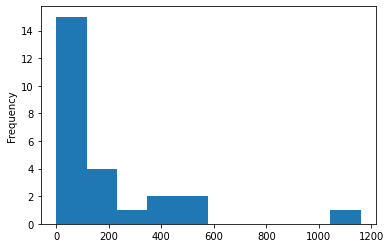

In [36]:
# distribution of post length
datasets_df['selftext'].map(lambda x: len(x)).plot(kind='hist');